In [165]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import shutil
import csv
import os

In [163]:
# 請分別輸入病人csv檔案,時間間隔,開始時間
# 檔案名稱請附上結尾.csv
# 時間間隔單位為分鐘
# 開始時間預定為早上8.
# ex : visualization('01A5.csv', 30)

def visualization(file, time_step, start=8):
    df = pd.read_csv(file, header = None)
    df[0] = [dt.datetime.strptime(i, '%Y/%m/%d').date() for i in df[0].values]
    df[1] = [dt.datetime.strptime(i, '%H:%M:%S').time() for i in df[1].values]
    date_list = np.sort(list(dict.fromkeys(df[0].values)))
    
    today_date = date_list[-1] # 定義今天時間
    time_zone = file[:4] + '_' + str(today_date) + ' box plot' 
    
    date = df[0].values
    d_filter = (date>=today_date)&(date<today_date+datetime.timedelta(days = 1))
    
    data = (df[3].values)[d_filter]/100 # each date
    time = (df[1].values)[d_filter] # each hour
   
    start_datetime = datetime.datetime.combine(today_date, datetime.time(start,0))
    end_datetime = datetime.datetime.combine(today_date, time[-1])
    datetime_list = [(start_datetime+i*datetime.timedelta(minutes = time_step)) for i in range(int(np.floor((end_datetime-start_datetime)/datetime.timedelta(minutes = time_step))))]
    
    each_hour = []
    for t_idx in range(len(datetime_list)):
        t_filter = (time>=datetime_list[t_idx].time()) & (time<(datetime_list[t_idx]+datetime.timedelta(minutes = time_step)).time())
        tmp = data[(t_filter)&(data>25)&(data<45)]
        each_hour.append(tmp)
        
    plt.figure(figsize = (10,5))
    box_plot = plt.boxplot(each_hour, flierprops = dict(markerfacecolor = 'b', marker = '.'))
    baseline = plt.plot(np.linspace(1, time_step, time_step), [35 for i in range(time_step)], 'g:')
    l1 = plt.legend(baseline, ['baseline'], loc='lower right')
    
#     將medians, q1, q3分別記錄下來 並存成csv
    med_data = [] # med_data = [['date', 'time', 'q1', 'q3', 'medians']]
    for q_idx in range(len(box_plot['medians'])):
        med = box_plot['medians'][q_idx].get_ydata()
        q1 = box_plot['whiskers'][2*q_idx].get_ydata()
        q3 = box_plot['whiskers'][2*q_idx+1].get_ydata()
        tmp = [str(today_date), q_idx+1, q1[0], q3[0], med[0]]
        med_data.append(tmp)
#     存成csv檔
    with open(file[:4] + '_medians.csv' , 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        med_df = pd.DataFrame(med_data)
        writer.writerows(med_data)

#     讀取耳溫的csv檔 並在圖表上標點
    sick_hour, sick_tmp = read_tmp_to_list('01A5_ear.csv', today_date, datetime.time(start, 0), time_step, 34)
    sick_points = plt.scatter(sick_hour, sick_tmp,  marker = 'D', color='r' )
    plt.legend([sick_points], ['sick points'], loc='upper right')

#     美化圖表
    plt.gca().add_artist(l1)
    time_tag = [datetime.datetime.strftime(i, "%H:%M") for i in datetime_list]
    plt.xticks(np.linspace(1, time_step, time_step), time_tag, rotation='vertical')
    plt.xlabel('Hours')
    plt.ylabel('Temperature')
    plt.suptitle(time_zone)
#     plt.savefig( time_zone + '.png', dpi = 300)
    plt.show()


/home/math/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


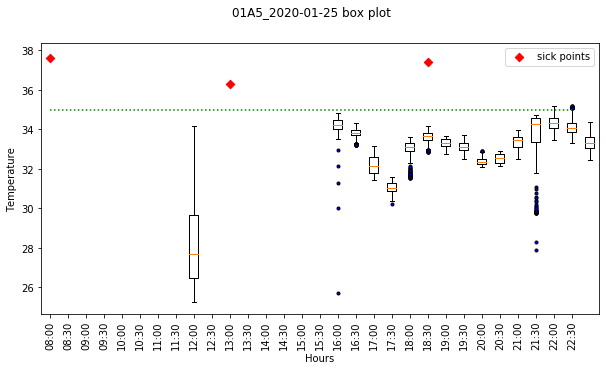

In [164]:
# 範例執行方式 :
# q1,q3,medium 串起來變成csv

visualization( '01A5.csv', 30 )

In [98]:
# 讀取耳溫量測表的資料 在主程式會用到

def read_tmp_to_list(file, today_date, today_start_time, time_step, warning_cri = 37):
    
    df = pd.read_csv(file, header = None, skiprows=1)
    df[0] = [dt.datetime.strptime(i, '%Y-%m-%d').date() for i in df[0].values]
    df[1] = [dt.datetime.strptime(i, '%H:%M').time() for i in df[1].values]
    if (type(today_date ) != datetime.date) | (type(today_start_time) != datetime.time):
        print("ERROR DATA TYPE")
        return 0
    else:
        today_datetime = datetime.datetime.combine(today_date, today_start_time)

    df_ear_warn = df[(df[2]>warning_cri)&(df[0]==today_date)&(df[1]>=today_start_time)]
    
    df_ear_warn[1] = [np.floor((datetime.datetime.combine(today_date, i)-today_datetime)/datetime.timedelta(minutes = time_step)) for i in df_ear_warn[1].values]
    
    return 1+df_ear_warn[1].values, df_ear_warn[2].values